Universidad Torcuato Di Tella

Licenciatura en Tecnología Digital\
**Tecnología Digital VI: Inteligencia Artificial**


In [73]:
!pip install torchaudio
!pip install  pydub
import os
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
import torchaudio.transforms as tt
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline



# TP3: Encodeador de música



## Orden de pasos

0. Elijan GPU para que corra mas rapido (RAM --> change runtime type --> T4 GPU)
1. Descargamos el dataset y lo descomprimimos en alguna carpeta en nuestro drive.
2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.
3. Visualización de los archivos
4. Clasificación
5. Evaluación




In [74]:
project_name='Music_genre_classification'

### 2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.





In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


data_dir es el path donde pusimos la carpeta genres. "'//content/drive/MyDrive/Materias/TD6 - Inteligencia Artificial/TPs/2023/TP4/genres/'" es un ejemplo. Modificar.

In [76]:
import os
data_dir='//content/drive/MyDrive/Materias/TD6 - Inteligencia Artificial/TPs/2023/TP4/genres_5sec/'
list_files=os.listdir(data_dir)
classes=[]
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)
classes

['country',
 'hiphop',
 'reggae',
 'jazz',
 'rock',
 'metal',
 'classical',
 'disco',
 'pop',
 'blues']

In [77]:
samplerate=22050
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

class MusicDataset(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files =[]
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))
        #self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]

        #img = self.transform(open_image(fpath))
        genre = parse_genres(fname)
        fpath = os.path.join(self.root,genre, fname)
        class_idx = self.classes.index(genre)
        audio = torchaudio.load(fpath)[0]

        return audio, class_idx
dataset = MusicDataset(data_dir)

### 3. Visualización de los archivos

In [78]:
waveform,label= dataset[0]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 9 


shape of spectogram torch.Size([1, 201, 552])


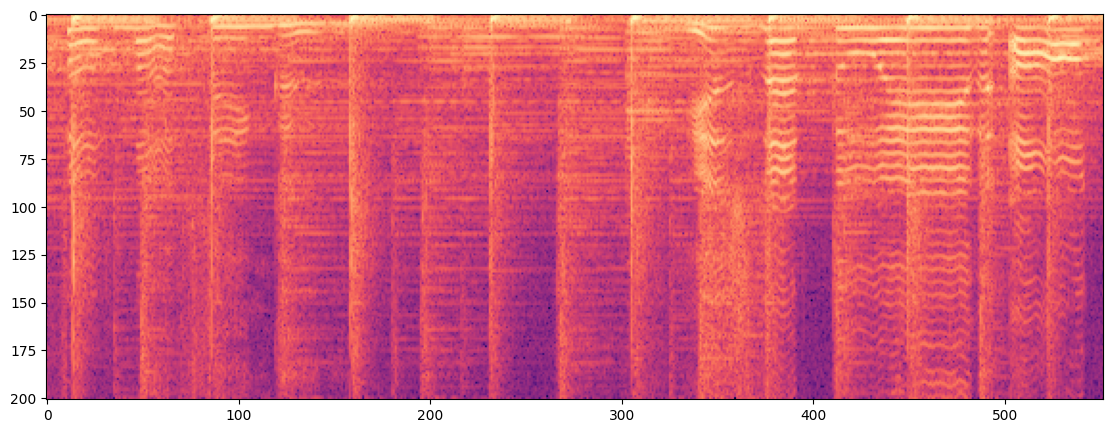

In [79]:
specgram=tt.Spectrogram()(waveform)
print("shape of spectogram {}".format(specgram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(specgram.log2()[0,:,:].numpy(),cmap='magma')


Waveform: tensor([[ 0.0023,  0.0143,  0.0239,  ..., -0.0585, -0.0594, -0.0644]])



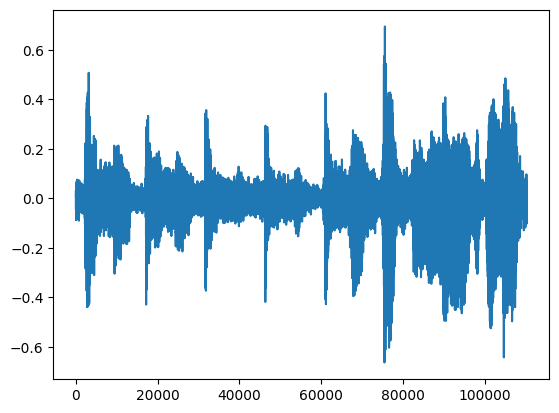

In [80]:
print("Waveform: {}\n".format(waveform))

plt.figure()
plt.plot(waveform.t().numpy())

Escuchamos el espectograma con la librería de audio

In [81]:
import IPython
IPython.display.Audio(waveform,rate=samplerate)

In [82]:
specgram.size()

torch.Size([1, 201, 552])

In [83]:
random_seed = 42
torch.manual_seed(random_seed);
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds),len(val_ds),len(test_ds)

(790, 100, 100)

In [84]:
from torch.utils.data import DataLoader
batch_size = 20

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds,1, num_workers=4, pin_memory=True)

### 4. Clasificación

In [85]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)




In [89]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cnn = M5(n_input=1, n_output=len(classes))
cnn.to(device)
print(cnn)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(cnn)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=10, bias=True)
)
Numbe

In [87]:
len(classes)

10

In [90]:
import gc
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.nn.functional as F

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0005)
valid_losses = []
num_epochs = 30
torch.cuda.empty_cache()
gc.collect() #importante para ir liberando memoria ram
for epoch in range(num_epochs):
    losses = []

    # Train
    cnn.train()
    for wav, genre_index in train_dl:
        optimizer.zero_grad()  # Clear gradients
        wav=wav.to(device)
        genre_index =torch.as_tensor(genre_index).to(device)

        # Forward
        out = cnn(wav)
        #M5
        loss = F.nll_loss(out.squeeze(), genre_index)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        del wav #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram
        torch.cuda.empty_cache()  #importante para ir liberando memoria ram
        gc.collect() #importante para ir liberando memoria ram

    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

    # Validation
    cnn.eval()
    y_true = []
    y_pred = []
    losses = []
    correct =0
    for wav, genre_index in valid_dl:
        #print(wav, genre, index)
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        out = cnn(wav)
        #M5
        loss = F.nll_loss(out.squeeze(), genre_index)

        losses.append(loss.item())
        #M5
        pred= out.argmax(dim=-1).flatten()
        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)
        del wav #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram
        torch.cuda.empty_cache()  #importante para ir liberando memoria ram
        gc.collect() #importante para ir liberando memoria ram

    accuracy =correct/ len(valid_dl.dataset)
    valid_loss = np.mean(losses)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))

    # Save model
    valid_losses.append(valid_loss.item())
    if np.argmin(valid_losses) == epoch:
        print('Saving the best model at %d epochs!' % epoch)
        torch.save(cnn.state_dict(), 'best_model.ckpt')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: [1/30], Train loss: 2.1070
Epoch: [1/30], Valid loss: 2.1805, Valid accuracy: 0.2100
Saving the best model at 0 epochs!
Epoch: [2/30], Train loss: 1.9087
Epoch: [2/30], Valid loss: 1.9245, Valid accuracy: 0.3300
Saving the best model at 1 epochs!
Epoch: [3/30], Train loss: 1.7652
Epoch: [3/30], Valid loss: 1.8810, Valid accuracy: 0.3600
Saving the best model at 2 epochs!
Epoch: [4/30], Train loss: 1.6834
Epoch: [4/30], Valid loss: 1.8672, Valid accuracy: 0.4400
Saving the best model at 3 epochs!
Epoch: [5/30], Train loss: 1.6128
Epoch: [5/30], Valid loss: 1.7290, Valid accuracy: 0.4500
Saving the best model at 4 epochs!
Epoch: [6/30], Train loss: 1.5378
Epoch: [6/30], Valid loss: 1.7345, Valid accuracy: 0.4000
Epoch: [7/30], Train loss: 1.4823
Epoch: [7/30], Valid loss: 1.6784, Valid accuracy: 0.4600
Saving the best model at 6 epochs!
Epoch: [8/30], Train loss: 1.4235
Epoch: [8/30], Valid loss: 1.6597, Valid accuracy: 0.4600
Saving the best model at 7 epochs!
Epoch: [9/30], Trai



### 5. Evaluación



In [92]:
test_dl = DataLoader(test_ds,1,shuffle=True, num_workers=4, pin_memory=True)

In [93]:
# Load the best model
S = torch.load('best_model.ckpt')
cnn.load_state_dict(S)
print('loaded!')

# Run evaluation
cnn.eval()
y_true = []
y_pred = []
correct = 0
with torch.no_grad():
    for wav, genre_index in test_dl:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        out = cnn(wav)

        pred= out.argmax(dim=-1).flatten()
        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)

accuracy =correct/ len(test_dl.dataset)
print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))


loaded!
Epoch: [30/30], Valid loss: 1.2784, Valid accuracy: 0.6100


In [94]:
waveform,label= test_dl.dataset[12]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 7 


In [95]:
import IPython
IPython.display.Audio(waveform, rate=22050)

In [96]:
wav= torch.unsqueeze(waveform, dim=0)
cnn.to(device)
wav =wav.to(device)
out = cnn(wav)
pred= out.argmax(dim=-1).flatten()
classes[pred], classes[label]

('disco', 'disco')